In [ ]:
!pip install livelossplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Automobile-parts'

img_width = 300
img_height = 300

EPOCHS = 20
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.initializers import GlorotUniform

from livelossplot import PlotLossesKeras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from os.path import isdir, isfile, join

In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.3,
    width_shift_range=0.5,
    brightness_range=[0.1,0.9],
    rotation_range=90,
    validation_split=0.1,
    zoom_range=0.1
)

In [ ]:
CLASSES = sorted(listdir(data_dir))
CLASSES

['Bevel-gear',
 'bearing',
 'clutch',
 'cylincer',
 'filter',
 'fuel-tank',
 'helical_gear',
 'piston',
 'rack-pinion',
 'shocker',
 'spark-plug',
 'spur-gear',
 'valve',
 'wheel']

In [ ]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='training',
    shuffle=True,
    seed=116,
)

validation_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='validation',
    shuffle=True,
    seed=116,
)

Found 627 images belonging to 14 classes.
Found 61 images belonging to 14 classes.


In [ ]:
model = Sequential()

# base_model
base_model = InceptionV3(include_top=False,input_shape=(img_width, img_height,3))
base_model.trainable=False

model.add(base_model)
l1_strength = 0.01

#### Fully-Connected Layer ####
initializer = GlorotUniform()
regularizer = l1(l1_strength)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))
model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
model.add(Dense(len(CLASSES), activation='softmax', kernel_initializer=initializer))
model.summary()

87910968/87910968 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 14)                14350     
                                                                 
Total params: 23915310 (91.23 MB)
Trainable params: 21125

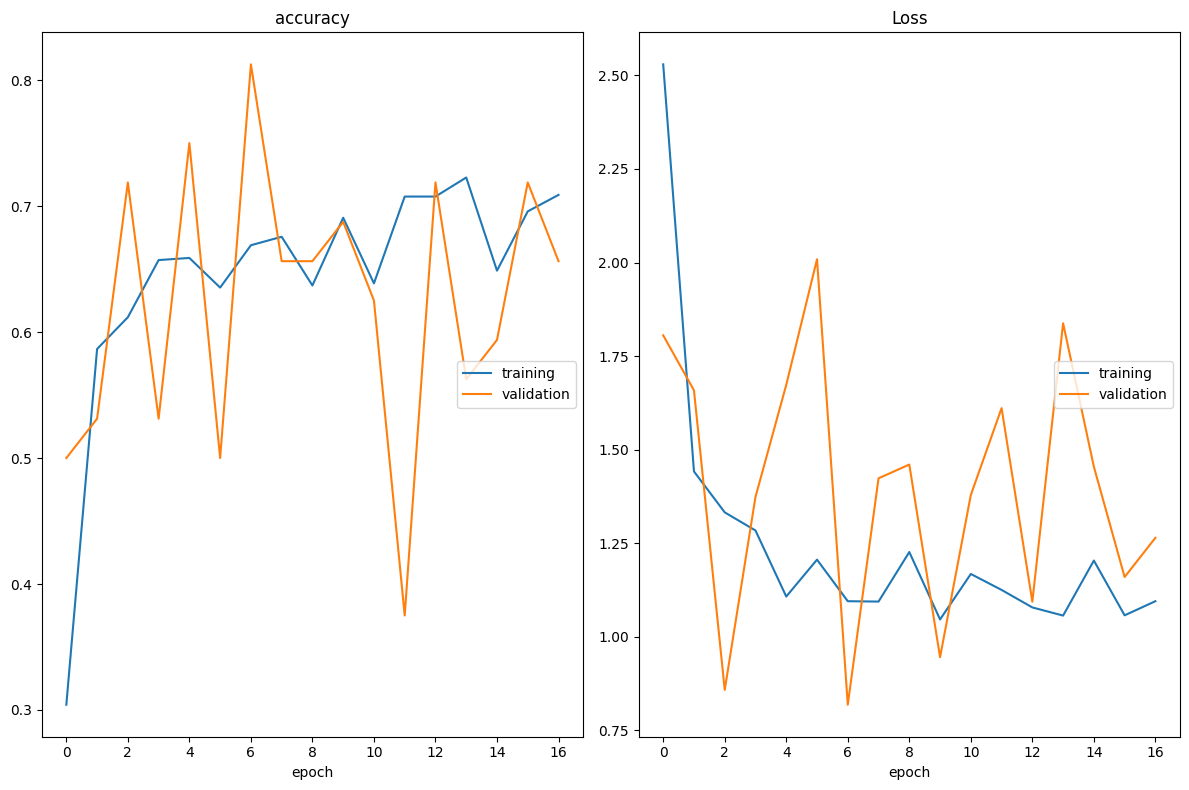

accuracy
	training         	 (min:    0.304, max:    0.723, cur:    0.709)
	validation       	 (min:    0.375, max:    0.812, cur:    0.656)
Loss
	training         	 (min:    1.046, max:    2.530, cur:    1.095)
	validation       	 (min:    0.818, max:    2.009, cur:    1.264)
19/19 [==============================] - 164s 9s/step - loss: 1.0950 - accuracy: 0.7089 - val_loss: 1.2644 - val_accuracy: 0.6562


In [ ]:
steps_for_each_epoch = train_gen.samples // BATCH_SIZE
validation_steps_for_each_epoch = validation_gen.samples // BATCH_SIZE

OPTIMIZER = SGD(learning_rate=0.1, momentum=0.9)

model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

## save model after every epoch ##
checkpointer = ModelCheckpoint(filepath='img_model.trained.weights.hdf5', verbose=1, save_best_only=True)

## Early stopping to stop over training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_for_each_epoch,
    validation_data=validation_gen,
    validation_steps=validation_steps_for_each_epoch,
    callbacks=[early_stop, checkpointer, PlotLossesKeras()],
    verbose=True
)

In [ ]:
test_loss, test_acc = model.evaluate(validation_gen)
print('test accuracy : ', test_acc)


trained_model = load_model('img_model.trained.weights.hdf5')

2/2 [==============================] - 16s 8s/step - loss: 1.0975 - accuracy: 0.6721
test accuracy :  0.6721311211585999


In [ ]:
def predict_img(img_path):
    img = image.load_img(data_dir+img_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = trained_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',CLASSES[np.argmax(p[0])])
    print("\n")

# This method is not used in this kernal, if running locally you can test the model performance by passing some unseen images to it
def predict_external_img(full_img_path):
    img = image.load_img(full_img_path, target_size=(300, 300))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    p = trained_model.predict(img[np.newaxis,...])
    print('Confidence: ',str(round(np.max(p[0])*100, 2))+'%')
    print('Class: ',CLASSES[np.argmax(p[0])])

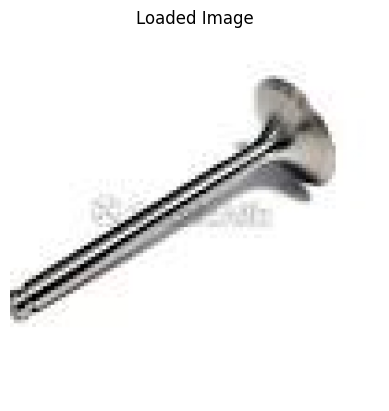

1/1 [==============================] - 2s 2s/step
Confidence:  98.61%
Class:  valve




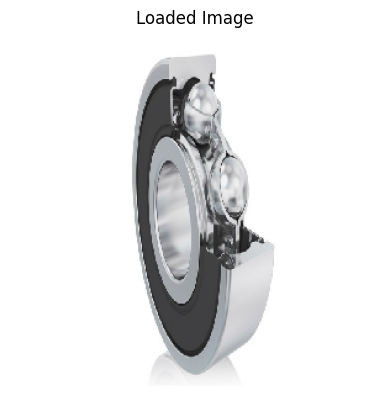

1/1 [==============================] - 0s 218ms/step
Confidence:  16.52%
Class:  spur-gear




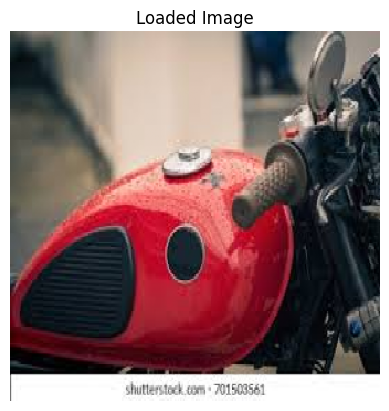

1/1 [==============================] - 0s 218ms/step
Confidence:  43.87%
Class:  fuel-tank




In [ ]:
predict_img('/valve/image (110).jpg')
predict_img('/bearing/image (13).jpg')
predict_img('/fuel-tank/image (13).jpg')